In [1]:
import os
import string
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('data/bbc-text.csv')
text = data['text'].values.tolist()
category = data['category'].values.tolist()
classes = list(set(category))
category = data['category'].apply(classes.index).values.tolist()

In [3]:

x_train, x_test, y_train, y_test = train_test_split(text, category, test_size=0.2, random_state=42)

In [4]:
stop_words = set(nltk.corpus.stopwords.words('english'))


In [5]:
# Building a vocabulary of words from the given documents
vocab = {}
for i in range(len(x_train)):
    word_list = []
    for word in x_train[i].split():
        word_new = word.strip(string.punctuation).lower()
        if(len(word_new) > 2) and (word_new not in stop_words):
            if word_new in vocab:
                vocab[word_new] += 1
            else:
                vocab[word_new] = 1

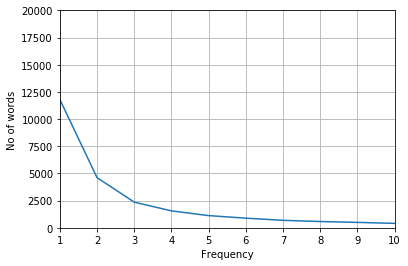

In [6]:
# plotting a graph of no of words with a given frequency to decide cut off frequency
num_words = [0 for i in range(max(vocab.values())+1)]
freq = [i for i in range(max(vocab.values()) + 1)]
for key in vocab:
    num_words[vocab[key]] += 1
plt.plot(freq, num_words)
plt.axis([1, 10, 0, 20000])
plt.xlabel("Frequency")
plt.ylabel("No of words")
plt.grid()
plt.show()

In [7]:
cutoff_freq = 80
# for deciding cutoff frequency
num_words_above_cutoff = len(vocab) - sum(num_words[0:cutoff_freq])
print("Number of words with frequency higher than cutoff frequency({}) :".format(cutoff_freq), num_words_above_cutoff)

Number of words with frequency higher than cutoff frequency(80) : 958


In [8]:
# words with frequency higher than cutoff frequency are choosen as features
# (i.e we remove words with low frequencies as they would not be significant )
features = []
for key in vocab:
    if vocab[key] >= cutoff_freq:
        features.append(key)
        

In [9]:
# to represent training data as word vector counts
x_train_dataset = np.zeros((len(x_train), len(features)))
# this can take some time to complete
for i in range(len(x_train)):
    word_list = [word.strip(string.punctuation).lower() for word in x_train[i].split()]
    for word in word_list:
        if word in features:
            x_train_dataset[i][features.index(word)] += 1

x_test_dataset = np.zeros((len(x_test), len(features)))
for i in range(len(x_test)):
    word_list = [word.strip(string.punctuation).lower() for word in x_test[i].split()]
    for word in word_list:
        if word in features:
            x_test_dataset[i][features.index(word)] += 1

In [10]:
# using sklearn;s Multinomial Navie Bayes
clf = MultinomialNB()
clf.fit(x_train_dataset, y_train)
y_test_pred = clf.predict(x_test_dataset)
sklearn_score_train = clf.score(x_train_dataset, y_train)
print("sklearn's score on training data :", sklearn_score_train)
sklearn_score_test = clf.score(x_test_dataset, y_test)
print("sklearn's score on testing data :", sklearn_score_test)
print("classification report for testing data :-")
print(classification_report(y_test, y_test_pred))

sklearn's score on training data : 0.9764044943820225
sklearn's score on testing data : 0.9415730337078652
classification report for testing data :-
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        83
           1       0.96      0.94      0.95        81
           2       0.96      0.95      0.95        98
           3       0.94      0.94      0.94        82
           4       0.93      0.92      0.93       101

    accuracy                           0.94       445
   macro avg       0.94      0.94      0.94       445
weighted avg       0.94      0.94      0.94       445



In [34]:
# implementing multimonial Naviw Bayes from scratch
class MultimonialNavieBayes:
    def __init__(self):
        # count is a dictionary which stores several dictionaries corresponding to each news category
        # each value in the subdictionary represents the freq of the key corresponding to that news category
        self.count = {}
        # classes represents the different news categories
        self.classes = None
        
    def fit(self, X_train, Y_train):
        # this can take some time to complete
        self.classes = set(Y_train)
        for class_ in self.classes:
            self.count[class_] = {}
            for i in range(len(X_train[0])):
                self.count[class_][i] = 0
            self.count[class_]['total'] = 0
            self.count[class_]['total_points'] = 0
        self.count['total_points'] = len(X_train)

        for i in range(len(X_train)):
            for j in range(len(X_train[0])):
                self.count[Y_train[i]][j] += X_train[i][j]
                self.count[Y_train[i]]['total'] += X_train[i][j]
            self.count[Y_train[i]]['total_points'] += 1

    def __probability(self, test_point, class_):
        log_prob = np.log(self.count[class_]['total_points']) - np.log(self.count['total_points'])
        total_words = len(test_point)
        for i in range(len(test_point)):
            current_word_prob = test_point[i] * (np.log(self.count[class_][i] + 1) - np.log(self.count[class_]['total'] + total_words))
            log_prob += current_word_prob

        return log_prob

    def __predictSinglePoint(self, test_point):
        best_class = None
        best_prob = None
        first_run = True

        for class_ in self.classes:
            log_probability_current_class = self.__probability(test_point, class_)
            if (first_run) or (log_probability_current_class > best_prob):
                best_class = class_
                best_prob = log_probability_current_class
                first_run = False

        return best_class

    def predict(self, X_test):
        # this can take some time to complete
        Y_pred = []
        for i in range(len(X_test)):
            Y_pred.append(self.__predictSinglePoint(X_test[i]))

        return Y_pred

    def score(self, Y_pred, Y_true):
        # return mean accuracy
        count = 0
        for i in range(len(Y_pred)):
            if Y_pred[i] == Y_true[i]:
                count += 1
        return count/len(Y_pred)



In [12]:
clf2 = MultimonialNavieBayes()
clf2.fit(x_train_dataset, y_train)
y_test_pred = clf2.predict(x_test_dataset)
our_score_test = clf2.score(y_test_pred, y_test)
print("our score on testing data :", our_score_test)
print("classification report for testing data :-")
print(classification_report(y_test, y_test_pred))

our score on testing data : 0.9415730337078652
classification report for testing data :-
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        83
           1       0.96      0.94      0.95        81
           2       0.96      0.95      0.95        98
           3       0.94      0.94      0.94        82
           4       0.93      0.92      0.93       101

    accuracy                           0.94       445
   macro avg       0.94      0.94      0.94       445
weighted avg       0.94      0.94      0.94       445



In [13]:
print("score of out model on test data:", our_score_test)
print("score of inbuilt sklearn;s MultinominalNB on the same data :", sklearn_score_test)

score of out model on test data: 0.9415730337078652
score of inbuilt sklearn;s MultinominalNB on the same data : 0.9415730337078652


In [14]:
print(classes)

['politics', 'entertainment', 'sport', 'tech', 'business']


In [20]:
## binary classification 
entertainment = data[data['category'] == 'entertainment']
not_entertainment = data[data['category'] != 'entertainment'].sample(n=len(entertainment))
balance_data = pd.concat([entertainment, not_entertainment])


In [22]:
from sklearn.utils import shuffle
new_data = shuffle(balance_data)

In [25]:
X = new_data['text'].values.tolist()
Y = new_data['category'].apply(classes.index).values.tolist()
for i in range(len(Y)):
    if Y[i] != 1:
        Y[i] = 0

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [32]:
# to represent training data as word vector counts
x_train_dataset = np.zeros((len(x_train), len(features)))
# this can take some time to complete
for i in range(len(x_train)):
    word_list = [word.strip(string.punctuation).lower() for word in x_train[i].split()]
    for word in word_list:
        if word in features:
            x_train_dataset[i][features.index(word)] += 1

x_test_dataset = np.zeros((len(x_test), len(features)))
for i in range(len(x_test)):
    word_list = [word.strip(string.punctuation).lower() for word in x_test[i].split()]
    for word in word_list:
        if word in features:
            x_test_dataset[i][features.index(word)] += 1

In [33]:
# using sklearn;s Multinomial Navie Bayes
clf = MultinomialNB()
clf.fit(x_train_dataset, y_train)
y_test_pred = clf.predict(x_test_dataset)
sklearn_score_train = clf.score(x_train_dataset, y_train)
print("sklearn's score on training data :", sklearn_score_train)
sklearn_score_test = clf.score(x_test_dataset, y_test)
print("sklearn's score on testing data :", sklearn_score_test)
print("classification report for testing data :-")
print(classification_report(y_test, y_test_pred))

sklearn's score on training data : 0.9777777777777777
sklearn's score on testing data : 0.9698275862068966
classification report for testing data :-
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       118
           1       1.00      0.94      0.97       114

    accuracy                           0.97       232
   macro avg       0.97      0.97      0.97       232
weighted avg       0.97      0.97      0.97       232

